### Import libs

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.utils import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.losses import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers



---



In [2]:
from model import *
from train import *
from input_utils import *



---



In [3]:
name = "exp-v0-2024-07-27"
test_data_path = 'base_dataset/validation'
test_annotation_filename = 'validation_annotation.txt'

config_output_filename = os.path.join(name, 'model_vgg_config.pickle')

In [4]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

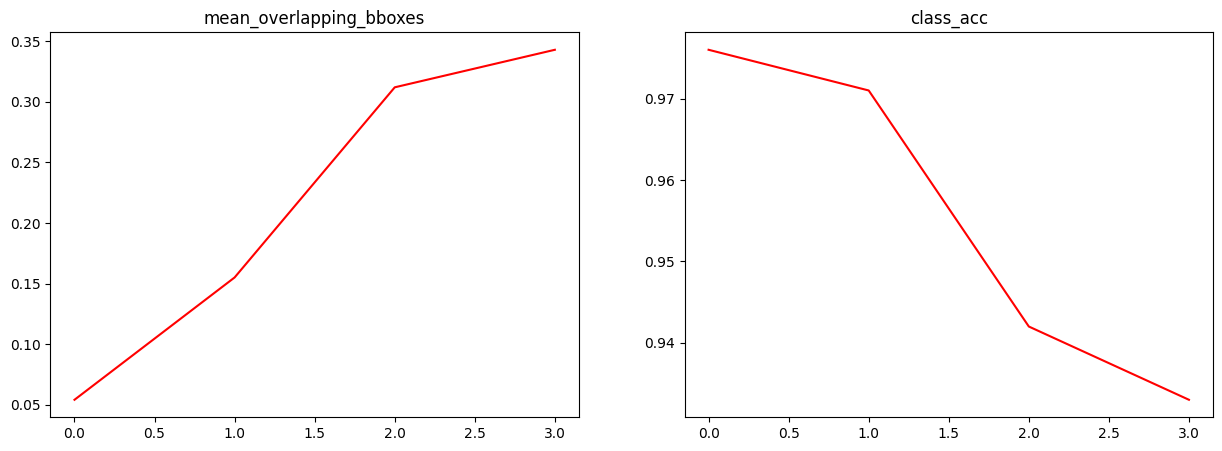

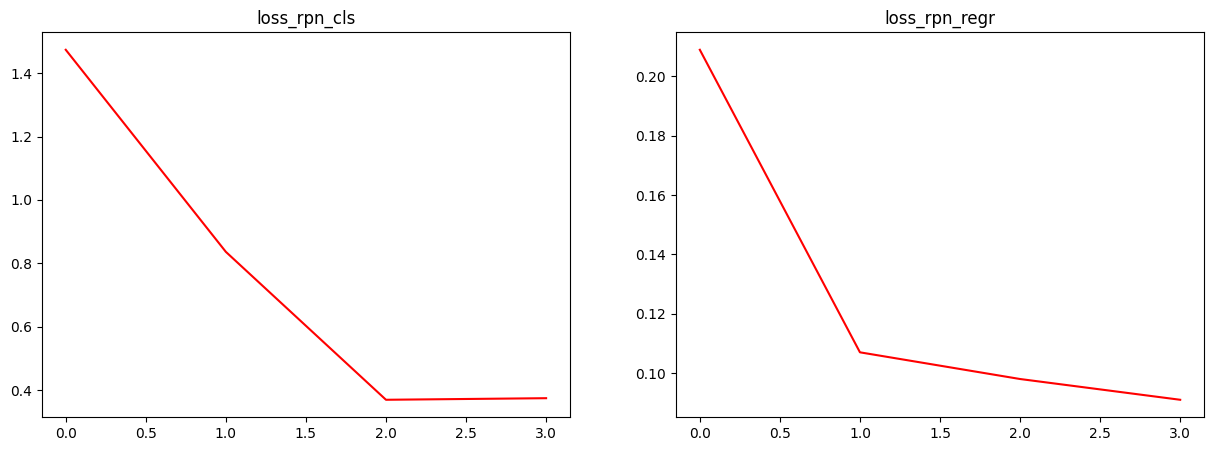

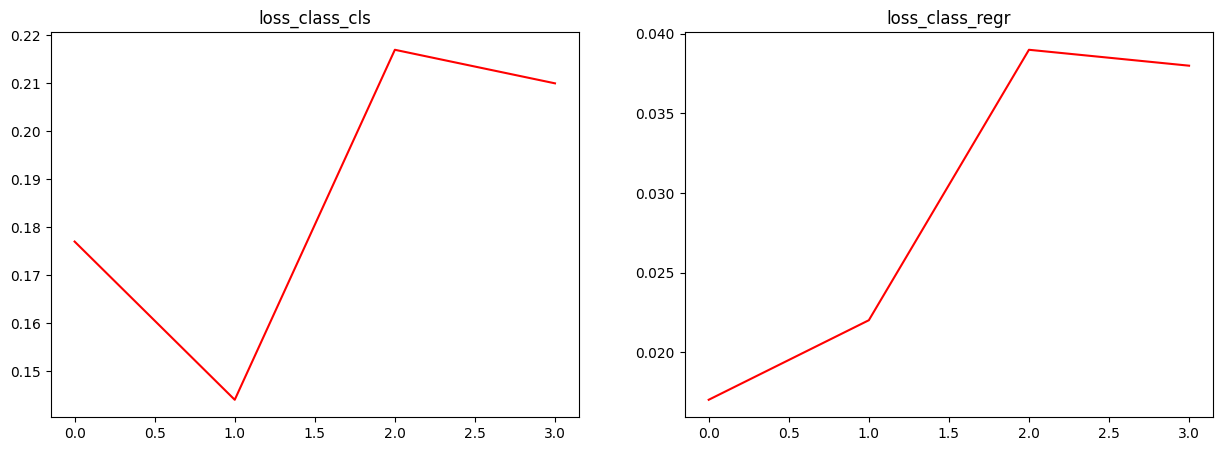

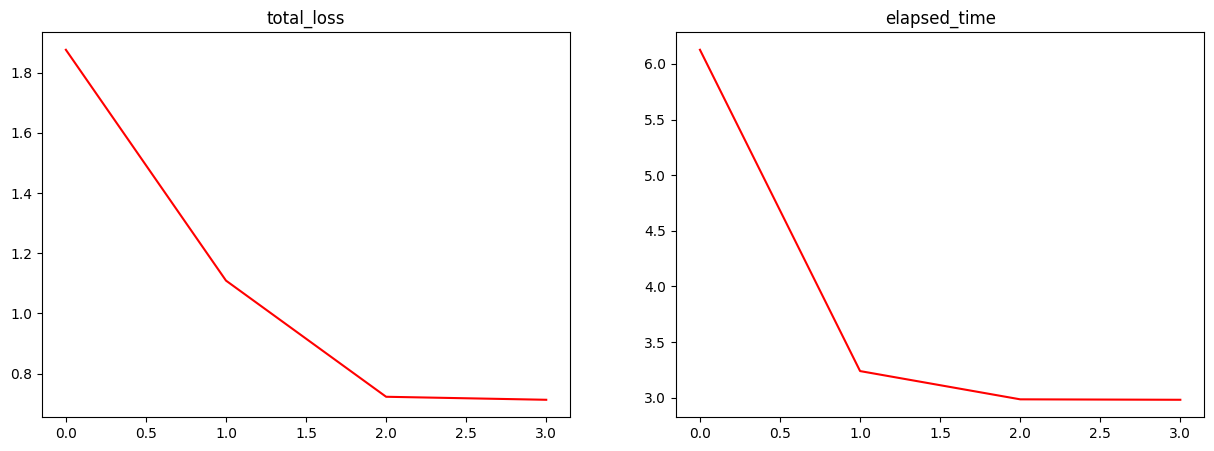

In [5]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

# Test

In [6]:
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    img = img.reshape(new_width, new_height, 1)
    return img, ratio	

def format_img_channels(img, C):
    """ formats the image channels based on config """
    x, y = img.shape
    img = img.reshape(x, y, 1)
    (rows,cols) = img.shape[:2]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):
    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

In [7]:
num_features = 512

input_shape_img = (None, None, 1)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from exp-v0-2024-07-27\model_frcnn_vgg.hdf5


In [8]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'B', 2: 'bg', 1: 'M'}


In [17]:
# TODO load all images

test_imgs = os.listdir(test_data_path)

imgs_path = []
for i in range(12):
	idx = np.random.randint(len(test_imgs))
	imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}
imgs_path

['mdb238.pgm',
 'mdb158.pgm',
 'mdb243.pgm',
 'mdb111.pgm',
 'mdb077.pgm',
 'mdb259.pgm',
 'mdb194.pgm',
 'mdb135.pgm',
 'mdb286.pgm',
 'mdb039.pgm',
 'mdb261.pgm',
 'mdb217.pgm']

In [12]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_data_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

#### Measure mAP

In [18]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P

In [20]:
def format_img_map(img, C):
    """Format image for mAP. Resize original image to C.im_size (300 in here)

    Args:
        img: cv2 image
        C: config

    Returns:
        img: Scaled and normalized image with expanding dimension
        fx: ratio for width scaling
        fy: ratio for height scaling
    """

    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        f = img_min_side/width
        new_height = int(f * height)
        new_width = int(img_min_side)
    else:
        f = img_min_side/height
        new_width = int(f * width)
        new_height = int(img_min_side)
    fx = width/float(new_width)
    fy = height/float(new_height)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    img = img.reshape(new_width, new_height, 1)
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img /= C.img_scaling_factor
    # Change img shape from (height, width, channel) to (channel, height, width)
    img = np.transpose(img, (2, 0, 1))
    # Expand one dimension at axis 0
    # img shape becames (1, channel, height, width)
    img = np.expand_dims(img, axis=0)
    return img, fx, fy

In [21]:
print(class_mapping)

{0: 'B', 2: 'bg', 1: 'M'}


In [22]:
test_imgs, _, _ = get_data(test_annotation_filename, test_data_path)

Parsing annotation file
idx=1
Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).
reading base_dataset/validation\mdb011.pgm
idx=2
reading base_dataset/validation\mdb014.pgm
idx=3
reading base_dataset/validation\mdb015.pgm
idx=4
reading base_dataset/validation\mdb021.pgm
idx=5
reading base_dataset/validation\mdb022.pgm
idx=6
reading base_dataset/validation\mdb024.pgm
idx=7
reading base_dataset/validation\mdb027.pgm
idx=8
reading base_dataset/validation\mdb032.pgm
idx=9
reading base_dataset/validation\mdb033.pgm
idx=10
reading base_dataset/validation\mdb039.pgm
idx=11
reading base_dataset/validation\mdb042.pgm
idx=12
reading base_dataset/validation\mdb050.pgm
idx=13
reading base_dataset/validation\mdb057.pgm
idx=14
reading base_dataset/validation\mdb070.pgm
idx=15
reading base_dataset/validation\mdb077.pgm
idx=16
reading base_dataset/validation\mdb086.pgm
idx=17
reading base_dataset/validation\mdb087.pgm
idx=18
readin

In [ ]:
T = {}
P = {}
mAPs = []
Y_pred = {}
for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    x, y = img.shape
    img = img.reshape(x, y, 1)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)

    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7) # NOTE changed from image_dim_ordering

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)

    # Debug
    Y_pred[filepath] = all_dets
    print(f"all_dets f{all_dets}")
    # Debug
    print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    #print(T)
    #print(P)
    
print()
print('mean average precision:', np.mean(np.array(mAPs)))

0/64
1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 6.915451288223267
bg AP: 1.0
mAP = 1.0
1/64
1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 4.248798608779907
bg AP: 1.0
mAP = 1.0
2/64
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 4.716568946838379
bg AP: 1.0
B AP: 1.0
mAP = 1.0
3/64
1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 4.5525758266448975
bg AP: 1.0
B AP: 1.0
mAP = 1.0
4/64
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 3.9411611557006836
bg AP: 1.0
B AP: 1.0
mAP = 1.0
5/64
1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 5.166965484619141
bg AP: 1.0
B AP: 1.0
mAP = 1.0
6/64
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 3.8224761486053467
bg AP: 1.0
B AP: 1.0
mAP = 1.0
7/64
1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 4.774101257324219
bg AP: 1.0
B AP: 1.0
mAP = 1.0
8/64
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
all_dets f[]
Elapsed time = 4.058293581008911
bg AP: 1.0
B AP: 1.0
mAP = 1.0
9/64
1/1 [==============================] - 0s 18ms/step


In [17]:
mAP = [mAP for mAP in mAPs if str(mAP)!='nan']
mean_average_prec = round(np.mean(np.array(mAP)), 3)
print('After training %dk batches, the mean average precision is %0.3f'%(len(record_df), mean_average_prec))

# record_df.loc[len(record_df)-1, 'mAP'] = mean_average_prec
# record_df.to_csv(C.record_path, index=0)
# print('Save mAP to {}'.format(C.record_path))

After training 40k batches, the mean average precision is 0.357


In [20]:
mAPs
# type(test_imgs)

[0.3333333333333333,
 0.3333333333333333,
 0.35555555555555557,
 0.3666666666666667,
 0.3650793650793651,
 0.3650793650793651,
 0.3650793650793651,
 0.3703703703703704,
 0.367816091954023,
 0.3636363636363636,
 0.3636363636363636,
 0.358974358974359,
 0.35507246376811596,
 0.35374149659863946,
 0.35028248587570626,
 0.35000000000000003,
 0.34825870646766166,
 0.34782608695652173,
 0.3474178403755868,
 0.3470319634703196,
 0.350210970464135,
 0.3525721935360489,
 0.3549043549043549,
 0.35804597701149427,
 0.3555096418732782,
 0.35493461730733816,
 0.3544871794871795,
 0.3544094794094794,
 0.35615079365079366,
 0.35822656091112465,
 0.35657366834914117,
 0.35749970953874755,
 0.35946086560660745,
 0.36051794638800544,
 0.36051794638800544,
 0.3600023165240556,
 0.3590608465608465,
 0.3585152949559729,
 0.3574122527874031,
 0.3568293226381462,
 0.356155303030303,
 0.3558070666504401,
 0.35700494284831635,
 0.35937245534987244,
 0.3586743634676837,
 0.35963018059087926,
 0.3588670548277535

In [24]:
print(np.mean([len(pred) for _, pred in Y_pred.items()]))
for f, pred in Y_pred.items():
#     print(f"{f} - {pred}")
    print(f"{f} - {len(pred)}")
    


8.78125
validation\mdb011.pgm - 8
validation\mdb014.pgm - 8
validation\mdb015.pgm - 11
validation\mdb021.pgm - 12
validation\mdb022.pgm - 10
validation\mdb024.pgm - 3
validation\mdb027.pgm - 0
validation\mdb032.pgm - 8
validation\mdb033.pgm - 2
validation\mdb039.pgm - 4
validation\mdb042.pgm - 4
validation\mdb050.pgm - 11
validation\mdb057.pgm - 15
validation\mdb070.pgm - 6
validation\mdb077.pgm - 14
validation\mdb086.pgm - 14
validation\mdb087.pgm - 8
validation\mdb088.pgm - 9
validation\mdb096.pgm - 6
validation\mdb100.pgm - 13
validation\mdb107.pgm - 10
validation\mdb111.pgm - 7
validation\mdb124.pgm - 12
validation\mdb126.pgm - 5
validation\mdb131.pgm - 14
validation\mdb135.pgm - 5
validation\mdb151.pgm - 8
validation\mdb154.pgm - 2
validation\mdb158.pgm - 12
validation\mdb160.pgm - 9
validation\mdb161.pgm - 11
validation\mdb175.pgm - 13
validation\mdb179.pgm - 2
validation\mdb181.pgm - 9
validation\mdb189.pgm - 0
validation\mdb194.pgm - 7
validation\mdb200.pgm - 15
validation\mdb2